In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import variable
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

import random

In [21]:
sample = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

In [22]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    num_workers = 1
    pin_memory = True
else:
    device = torch.device("cpu")
    num_workers = 4
    pin_memory = False
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

Using device: cuda:0
True
True


In [24]:
def plot_img(x):
    fig, axs = plt.subplots(3, 3)
    for i in range(3):
        for j in range(3):
            
            k = random.randint(0, 10000)
            axs[i, j].imshow(x[k].reshape(28, 28))
#plot_img(x)

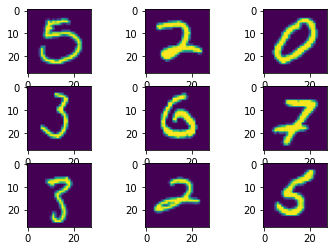

In [25]:
y = train['label'].values
x = (train.iloc[:,1:].values).astype('float32')
test = (test.iloc[:,:].values).astype('float32')
plot_img(x)

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2)

In [27]:
train_images = x_train.reshape(x_train.shape[0], 28, 28)
val_images = x_val.reshape(x_val.shape[0], 28, 28)
test_images = test.reshape(test.shape[0], 28, 28)

In [28]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
y_train_tensor = torch.tensor(y_train)
train_tensor = TensorDataset(train_images_tensor, y_train_tensor)

#val
val_images_tensor = torch.tensor(val_images)/255.0
y_val_tensor = torch.tensor(y_val)
val_tensor = TensorDataset(val_images_tensor, y_val_tensor)

#test
test_images_tensor = torch.tensor(test_images)/255.0

In [29]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [31]:
model = Net()
model

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [32]:
optimizer = optim.Adam(params=model.parameters(), lr=0.003)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [33]:
def train_model(num_epoch):
    model.train()
    exp_lr_scheduler.step()
    
    print('Train Epoch: {}'.format(num_epoch))
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
            
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        #loss += F.cross_entropy(output, target, size_average=False).data[0]

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    #loss /= len(data_loader.dataset)
        
    print('Val Accuracy:',100 * correct / len(data_loader.dataset),'\n')

In [34]:
num_epochs = 25

for n in range(num_epochs):
    train_model(n)
    evaluate(val_loader)

Train Epoch: 0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Val Accuracy: tensor(98.3690) 

Train Epoch: 1
Val Accuracy: tensor(98.5714) 

Train Epoch: 2
Val Accuracy: tensor(98.5833) 

Train Epoch: 3
Val Accuracy: tensor(98.8214) 

Train Epoch: 4
Val Accuracy: tensor(99.0238) 

Train Epoch: 5
Val Accuracy: tensor(99.) 

Train Epoch: 6
Val Accuracy: tensor(99.1786) 

Train Epoch: 7
Val Accuracy: tensor(99.2024) 

Train Epoch: 8
Val Accuracy: tensor(99.2738) 

Train Epoch: 9
Val Accuracy: tensor(99.2381) 

Train Epoch: 10
Val Accuracy: tensor(99.2262) 

Train Epoch: 11
Val Accuracy: tensor(99.2857) 

Train Epoch: 12
Val Accuracy: tensor(99.3333) 

Train Epoch: 13
Val Accuracy: tensor(99.3214) 

Train Epoch: 14
Val Accuracy: tensor(99.3452) 

Train Epoch: 15
Val Accuracy: tensor(99.2976) 

Train Epoch: 16
Val Accuracy: tensor(99.3095) 

Train Epoch: 17
Val Accuracy: tensor(99.2857) 

Train Epoch: 18
Val Accuracy: tensor(99.3571) 

Train Epoch: 19
Val Accuracy: tensor(99.2976) 

Train Epoch: 20
Val Accuracy: tensor(99.3929) 

Train Epoch: 21
Val A

In [36]:
def predict(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)   
        
        if torch.cuda.is_available():
            data = data.cuda()
        
        pred = model(data)
        preds = pred.cpu().data.max(1, keepdim=True)[1]
        
        test_pred = torch.cat((test_pred, preds), dim=0)
    
    return test_pred

test_set_preds = predict(test_loader)
print(test_set_preds)

tensor([[2],
        [0],
        [9],
        ...,
        [3],
        [9],
        [2]])


In [37]:
sample['Label'] = test_set_preds.numpy().squeeze()
sample.to_csv('submission.csv', index=False)